In [103]:
import pandas as pd
import numpy as np
from scipy.stats import ranksums

import glob
import os
import matplotlib.pyplot as plt

from modules.utilities import *
from modules.constants import *
from modules import CliffsDelta
from scipy.stats import shapiro

plt.rcParams.update(mpl_params)
TOPIC_DIR = "./Outputs/BERTopic/Topics"
DATA_DIR = "./Outputs/PerformancePRs"

In [ ]:
perf_df = pd.read_csv(os.path.join(DATA_DIR, "POP_PULL_Requests_LLM_filtered_final.csv"))
perf_ids = perf_df["id"].tolist()
perf_df = perf_df[~pd.isna(perf_df["merged_at"])]

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url
1,3273233066,1037,feat: implement comprehensive species tracking...,## Summary\nThis PR implements a comprehensive...,Claude_Code,7030001,tphakala,closed,2025-07-29T11:21:11Z,2025-07-29T13:49:45Z,2025-07-29T13:49:45Z,707764474,https://api.github.com/repos/tphakala/birdnet-go,https://github.com/tphakala/birdnet-go/pull/1037
2,3219880512,10340,feat(backend): Integrate GCS file storage with...,## Summary\n\nThis PR introduces a complete cl...,Claude_Code,76959103,majdyz,closed,2025-07-10T15:52:56Z,2025-07-18T03:20:54Z,2025-07-18T03:20:54Z,614765452,https://api.github.com/repos/Significant-Gravi...,https://github.com/Significant-Gravitas/AutoGP...
4,3142181649,19,Replace CLI subprocess approach with Claude Co...,## Description\n\nReplace the current CLI subp...,Claude_Code,80381,sugyan,closed,2025-06-13T04:05:15Z,2025-06-13T14:14:33Z,2025-06-13T14:14:33Z,999285986,https://api.github.com/repos/sugyan/claude-cod...,https://github.com/sugyan/claude-code-webui/pu...
5,3200679276,4304,Implement lazy loading for RegistryInstance to...,👨 \r\n\r\nBefore:\r\n\r\n```\r\njulia> @time P...,Claude_Code,1282691,KristofferC,closed,2025-07-03T21:18:03Z,2025-07-04T08:34:04Z,2025-07-04T08:34:04Z,82341193,https://api.github.com/repos/JuliaLang/Pkg.jl,https://github.com/JuliaLang/Pkg.jl/pull/4304
7,3250080019,24542,[fix][broker]Fix thread safety issues in Bucke...,### Motivation\r\n\r\nFixes #23190\r\n\r\nBuck...,Claude_Code,10327630,Apurva007,closed,2025-07-21T21:21:39Z,2025-07-22T06:17:01Z,2025-07-22T06:17:01Z,62117812,https://api.github.com/repos/apache/pulsar,https://github.com/apache/pulsar/pull/24542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,3080933474,8363,fix(api): Update mocha configuration to use SW...,# feat(api): Update API tests to use SWC inste...,Devin,158243242,devin-ai-integration[bot],closed,2025-05-21T17:17:57Z,2025-05-23T11:06:52Z,2025-05-23T11:06:52Z,400215964,https://api.github.com/repos/novuhq/novu,https://github.com/novuhq/novu/pull/8363
1201,3070322024,21374,perf: add p-limit to _getUsersAvailability to ...,# Add p-limit to _getUsersAvailability\n\n## D...,Devin,158243242,devin-ai-integration[bot],closed,2025-05-17T04:28:35Z,2025-05-17T21:05:45Z,2025-05-17T21:05:45Z,350360184,https://api.github.com/repos/calcom/cal.com,https://github.com/calcom/cal.com/pull/21374
1211,3240006620,7598,Change default hotstuff-min-timeout for collec...,Collection Node timeout default value is set f...,Devin,158243242,devin-ai-integration[bot],closed,2025-07-17T15:28:36Z,2025-07-17T21:03:27Z,2025-07-17T21:03:27Z,297778512,https://api.github.com/repos/onflow/flow-go,https://github.com/onflow/flow-go/pull/7598
1212,3240241128,582,Add performance benchmarks requirement to cont...,# Add performance benchmarks requirement to co...,Devin,158243242,devin-ai-integration[bot],closed,2025-07-17T16:47:16Z,2025-07-17T16:50:12Z,2025-07-17T16:50:12Z,955904085,https://api.github.com/repos/antiwork/flexile,https://github.com/antiwork/flexile/pull/582


In [8]:
pop_df = read_aidev(FileName.POP_PULL_REQUEST)
non_perf_df = pop_df[~pop_df["id"].isin(perf_ids)]
non_perf_df = non_perf_df[~pd.isna(non_perf_df["merged_at"])]
non_perf_df

,id,number,title,body,agent,user_id,user,state,created_at,closed_at,merged_at,repo_id,repo_url,html_url
1,3265118634,2,ファイルパス参照を相対パスに統一し、doc/からdocs/に統一,## 背景\n\n現在、本プロジェクトにおいて以下のパス構成の不整合が生じています：\n\n...,Claude_Code,61827001,cm-kojimat,closed,2025-07-26T04:56:55Z,2025-07-26T22:12:24Z,2025-07-26T22:12:24Z,1025472321,https://api.github.com/repos/classmethod/tsumiki,https://github.com/classmethod/tsumiki/pull/2
2,3265640341,30,Add build staleness detection for debug CLI,## Summary\r\n\r\n Implements comprehensive b...,Claude_Code,7475,MSch,closed,2025-07-26T13:31:19Z,2025-07-26T13:37:22Z,2025-07-26T13:37:22Z,988488798,https://api.github.com/repos/steipete/Peekaboo,https://github.com/steipete/Peekaboo/pull/30
3,3265709660,205,feat: add comprehensive README screenshots wit...,## Type of Change\n\n- [ ] 🐛 `bug` - Bug fix (...,Claude_Code,80381,sugyan,closed,2025-07-26T14:07:22Z,2025-07-26T14:45:30Z,2025-07-26T14:45:30Z,999285986,https://api.github.com/repos/sugyan/claude-cod...,https://github.com/sugyan/claude-code-webui/pu...
18,3214555104,16658,Add function signature breaking change detector,<details><summary>&#x1F6E0 DevTools &#x1F6E0</...,Claude_Code,17039389,harupy,closed,2025-07-09T05:35:26Z,2025-07-11T05:13:35Z,2025-07-11T05:13:35Z,136202695,https://api.github.com/repos/mlflow/mlflow,https://github.com/mlflow/mlflow/pull/16658
19,3214724259,5489,feat: add comprehensive test coverage for form...,## Summary\n\nThis PR enhances the forms plugi...,Claude_Code,82053242,wtfsayo,closed,2025-07-09T06:43:46Z,2025-07-09T06:44:02Z,2025-07-09T06:44:01Z,826170402,https://api.github.com/repos/elizaOS/eliza,https://github.com/elizaOS/eliza/pull/5489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33587,2857168507,1410,Add close button to settings modal,"Added X button to close settings modal, positi...",Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T08:45:02Z,2025-02-17T19:17:14Z,2025-02-17T19:17:14Z,820087727,https://api.github.com/repos/onlook-dev/onlook,https://github.com/onlook-dev/onlook/pull/1410
33588,2857171695,1411,refactor: Port measurement overlay to React,Restores the alt to measure behavior using Rea...,Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T08:46:25Z,2025-02-18T04:51:00Z,2025-02-18T04:51:00Z,820087727,https://api.github.com/repos/onlook-dev/onlook,https://github.com/onlook-dev/onlook/pull/1411
33590,2857777582,1,"feat: unify button styles, enhance API key dia...","# UI Enhancements: Button Styles, API Key Dial...",Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T12:54:05Z,2025-02-17T13:35:03Z,2025-02-17T13:35:03Z,934090141,https://api.github.com/repos/jina-ai/deepsearc...,https://github.com/jina-ai/deepsearch-ui/pull/1
33591,2857942945,2,fix: improve dark mode input focus and toggle ...,# UI Improvements: Dark Mode Input Focus and T...,Devin,158243242,devin-ai-integration[bot],closed,2025-02-17T13:57:22Z,2025-02-17T14:40:12Z,2025-02-17T14:40:12Z,934090141,https://api.github.com/repos/jina-ai/deepsearc...,https://github.com/jina-ai/deepsearch-ui/pull/2


In [27]:
topics = {}
for topic_file in glob.glob(os.path.join(TOPIC_DIR, "*.csv")):
    if "-1" not in topic_file:
        topic_name = os.path.basename(topic_file).replace(".csv", "")
        df = pd.read_csv(topic_file)
        df = df[~pd.isna(df["merged_at"])]
        topics[topic_name] = df

In [ ]:
def get_time_to_merge(df, unit='days'):
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['merged_at'] = pd.to_datetime(df['merged_at'])
    time_diff = (df['merged_at'] - df['created_at']).dt.total_seconds()
    
    if unit == 'days':
        time_to_merge = time_diff / 86400
    elif unit == 'hours':
        time_to_merge = time_diff / 3600
    elif unit == 'minutes':
        time_to_merge = time_diff / 60
    elif unit == 'seconds':
        time_to_merge = time_diff
    else:
        raise ArgumentError("Invalid unit. Use 'days', 'hours', 'minutes', or 'seconds'.")
    
    return time_to_merge


def get_merge_stats(df, name):
    time_to_merge = get_time_to_merge(df)

    stats = {
        'name': name,
        'min': time_to_merge.min(),
        'max': time_to_merge.max(),
        'mean': time_to_merge.mean(),
        'median': time_to_merge.median(),
        '10th': time_to_merge.quantile(0.1),
        '90th': time_to_merge.quantile(0.9),
    }d_at']).dt.total_seconds()
    
    if unit == 'days':
        time_to_merge = time_diff / 86400

    return stats

# General Stat Table

In [81]:
rows = [get_merge_stats(perf_df, "Performance"), get_merge_stats(non_perf_df, "Non-Performance")]
for topic, df in topics.items():
    rows.append(get_merge_stats(df, topic))
stat = pd.DataFrame(rows)

In [82]:
stat
    print(topic)

,name,min,max,mean,median,10th,90th
0,Performance,0.000081,67.746898,1.193850,0.002969,0.000127,2.345816
1,Non-Performance,0.000046,74.904097,0.798604,0.001887,0.000139,1.023009
2,topic_12,0.000116,5.359271,0.852622,0.079769,0.021449,2.296688
3,topic_15,0.000220,9.698576,0.747417,0.001759,0.000282,0.004495
4,topic_35,0.000081,1.072002,0.108184,0.000949,0.000093,0.250877
5,topic_43,0.000093,7.182442,0.659271,0.010093,0.000150,0.011435
6,topic_38,0.066030,56.062928,18.442381,8.820284,1.778794,42.803647
7,topic_28,0.001100,6.985625,1.306007,0.055272,0.001140,3.861609
8,topic_3,0.000127,48.547894,3.896238,0.232535,0.000463,6.718380
9,topic_21,0.000127,0.010741,0.002314,0.000243,0.000139,0.010486


# Perf vs Non-Perf

## Boxplot

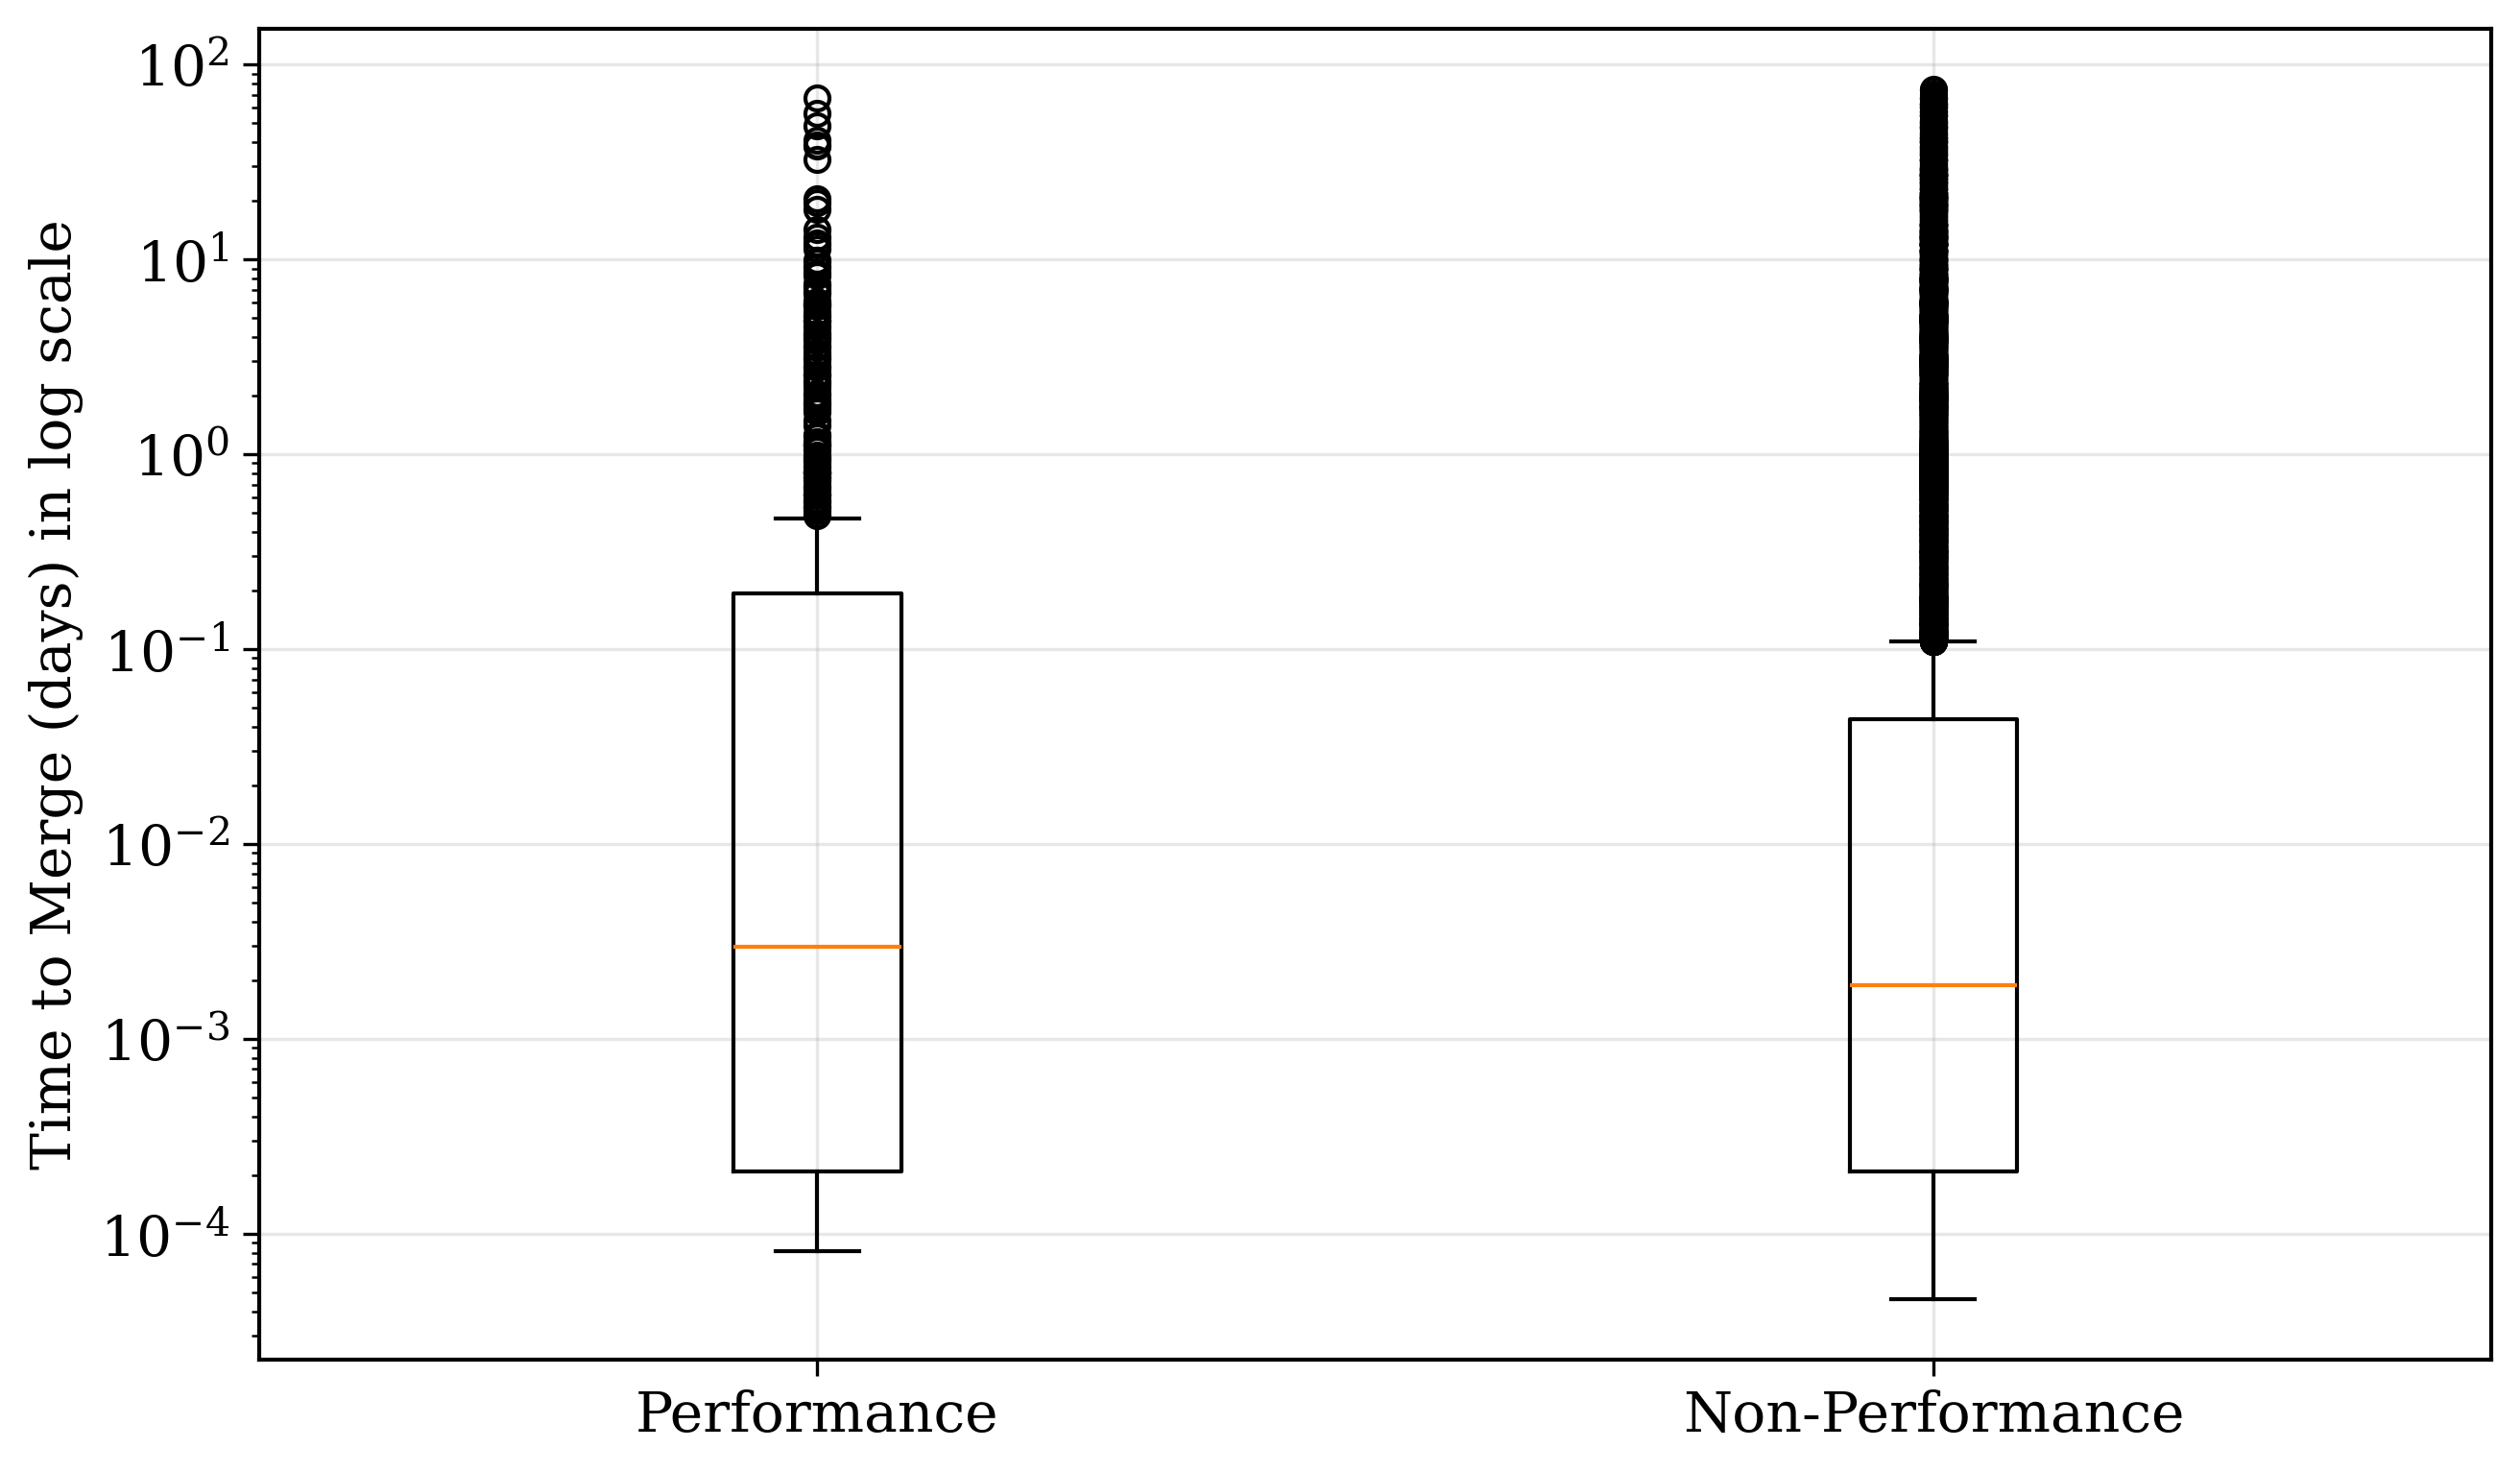

In [88]:
unit = "days"
times_to_merge = [get_time_to_merge(perf_df, unit), get_time_to_merge(non_perf_df, unit)]
labels = ['Performance', 'Non-Performance']


stat = pd.DataFrame({
    'Topic': labels,
    'Median': [np.median(t) for t in times_to_merge],
    'TimeToMerge': times_to_merge
})

stat = stat.sort_values(by='Median', ascending=False)

plt.figure(figsize=(10, 6))
plt.boxplot(stat["TimeToMerge"], tick_labels=stat["Topic"])
plt.yscale('log')
plt.xticks(rotation=0, ha='center')
plt.ylabel(f'Time to Merge ({unit}) in log scale')
plt.grid(True, alpha=0.3)
plt.show()


## Statistical Difference

### Normality Test

In [107]:
# Check if distributions are normal using Shapiro-Wilk test

perf_times = get_time_to_merge(perf_df, unit='days')
non_perf_times = get_time_to_merge(non_perf_df, unit='days')

print("Normality Test (Shapiro-Wilk Test)")
print("=" * 70)

# Test for Performance PRs
perf_stat, perf_p = shapiro(perf_times)
print(f"Performance PRs:")
print(f"  Test Statistic: {perf_stat:.6f}")
print(f"  P-value: {perf_p:.6e}")
print(f"  Distribution: {'Normal' if perf_p > 0.05 else 'Not Normal'} (at α=0.05)")
print()

# Test for Non-Performance PRs
non_perf_stat, non_perf_p = shapiro(non_perf_times)
print(f"Non-Performance PRs:")
print(f"  Test Statistic: {non_perf_stat:.6f}")
print(f"  P-value: {non_perf_p:.6e}")
print(f"  Distribution: {'Normal' if non_perf_p > 0.05 else 'Not Normal'} (at α=0.05)")
print()


Normality Test (Shapiro-Wilk Test)
Performance PRs:
  Test Statistic: 0.226394
  P-value: 6.209665e-46
  Distribution: Not Normal (at α=0.05)

Non-Performance PRs:
  Test Statistic: 0.203866
  P-value: 8.526132e-134
  Distribution: Not Normal (at α=0.05)



/home/cs/grad/opumni/Research/MSR-MiningChallenge26/.conda/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 23346.
  res = hypotest_fun_out(*samples, **kwds)


In [109]:
# Perform Wilcoxon rank-sum test (Mann-Whitney U test) between Performance and Non-Performance

statistic, p_value = ranksums(perf_times, non_perf_times)

print("Wilcoxon Rank-Sum Test (Mann-Whitney U Test)")
print("=" * 50)
print(f"\nTest Statistic: {statistic:.4f}")
print(f"P-value: {p_value:.6f}")

if p_value < 0.001:
    print("Result: Statistically significant difference (p < 0.001)")
if p_value < 0.01:
    print("Result: Statistically significant difference (p < 0.01)")
if p_value < 0.05:
    print("Result: Statistically significant difference (p < 0.05)")
else:
    print("Result: No statistically significant difference (p >= 0.05)")

Wilcoxon Rank-Sum Test (Mann-Whitney U Test)

Test Statistic: 2.6066
P-value: 0.009144
Result: Statistically significant difference (p < 0.01)
Result: Statistically significant difference (p < 0.05)


In [110]:
delta, size = CliffsDelta.cliffsDelta(perf_times, non_perf_times)

print("Cliff's Delta Effect Size Analysis")
print("=" * 50)
print(f"\nCliff's Delta: {delta:.4f}")
print(f"Effect Size: {size}")
    print(topic)

Cliff's Delta Effect Size Analysis

Cliff's Delta: 0.0591
Effect Size: negligible

Interpretation: Performance PRs tend to have longer merge times than Non-Performance PRs


# All topic

## Boxplot

/home/cs/grad/opumni/Research/MSR-MiningChallenge26/.conda/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cs/grad/opumni/Research/MSR-MiningChallenge26/.conda/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


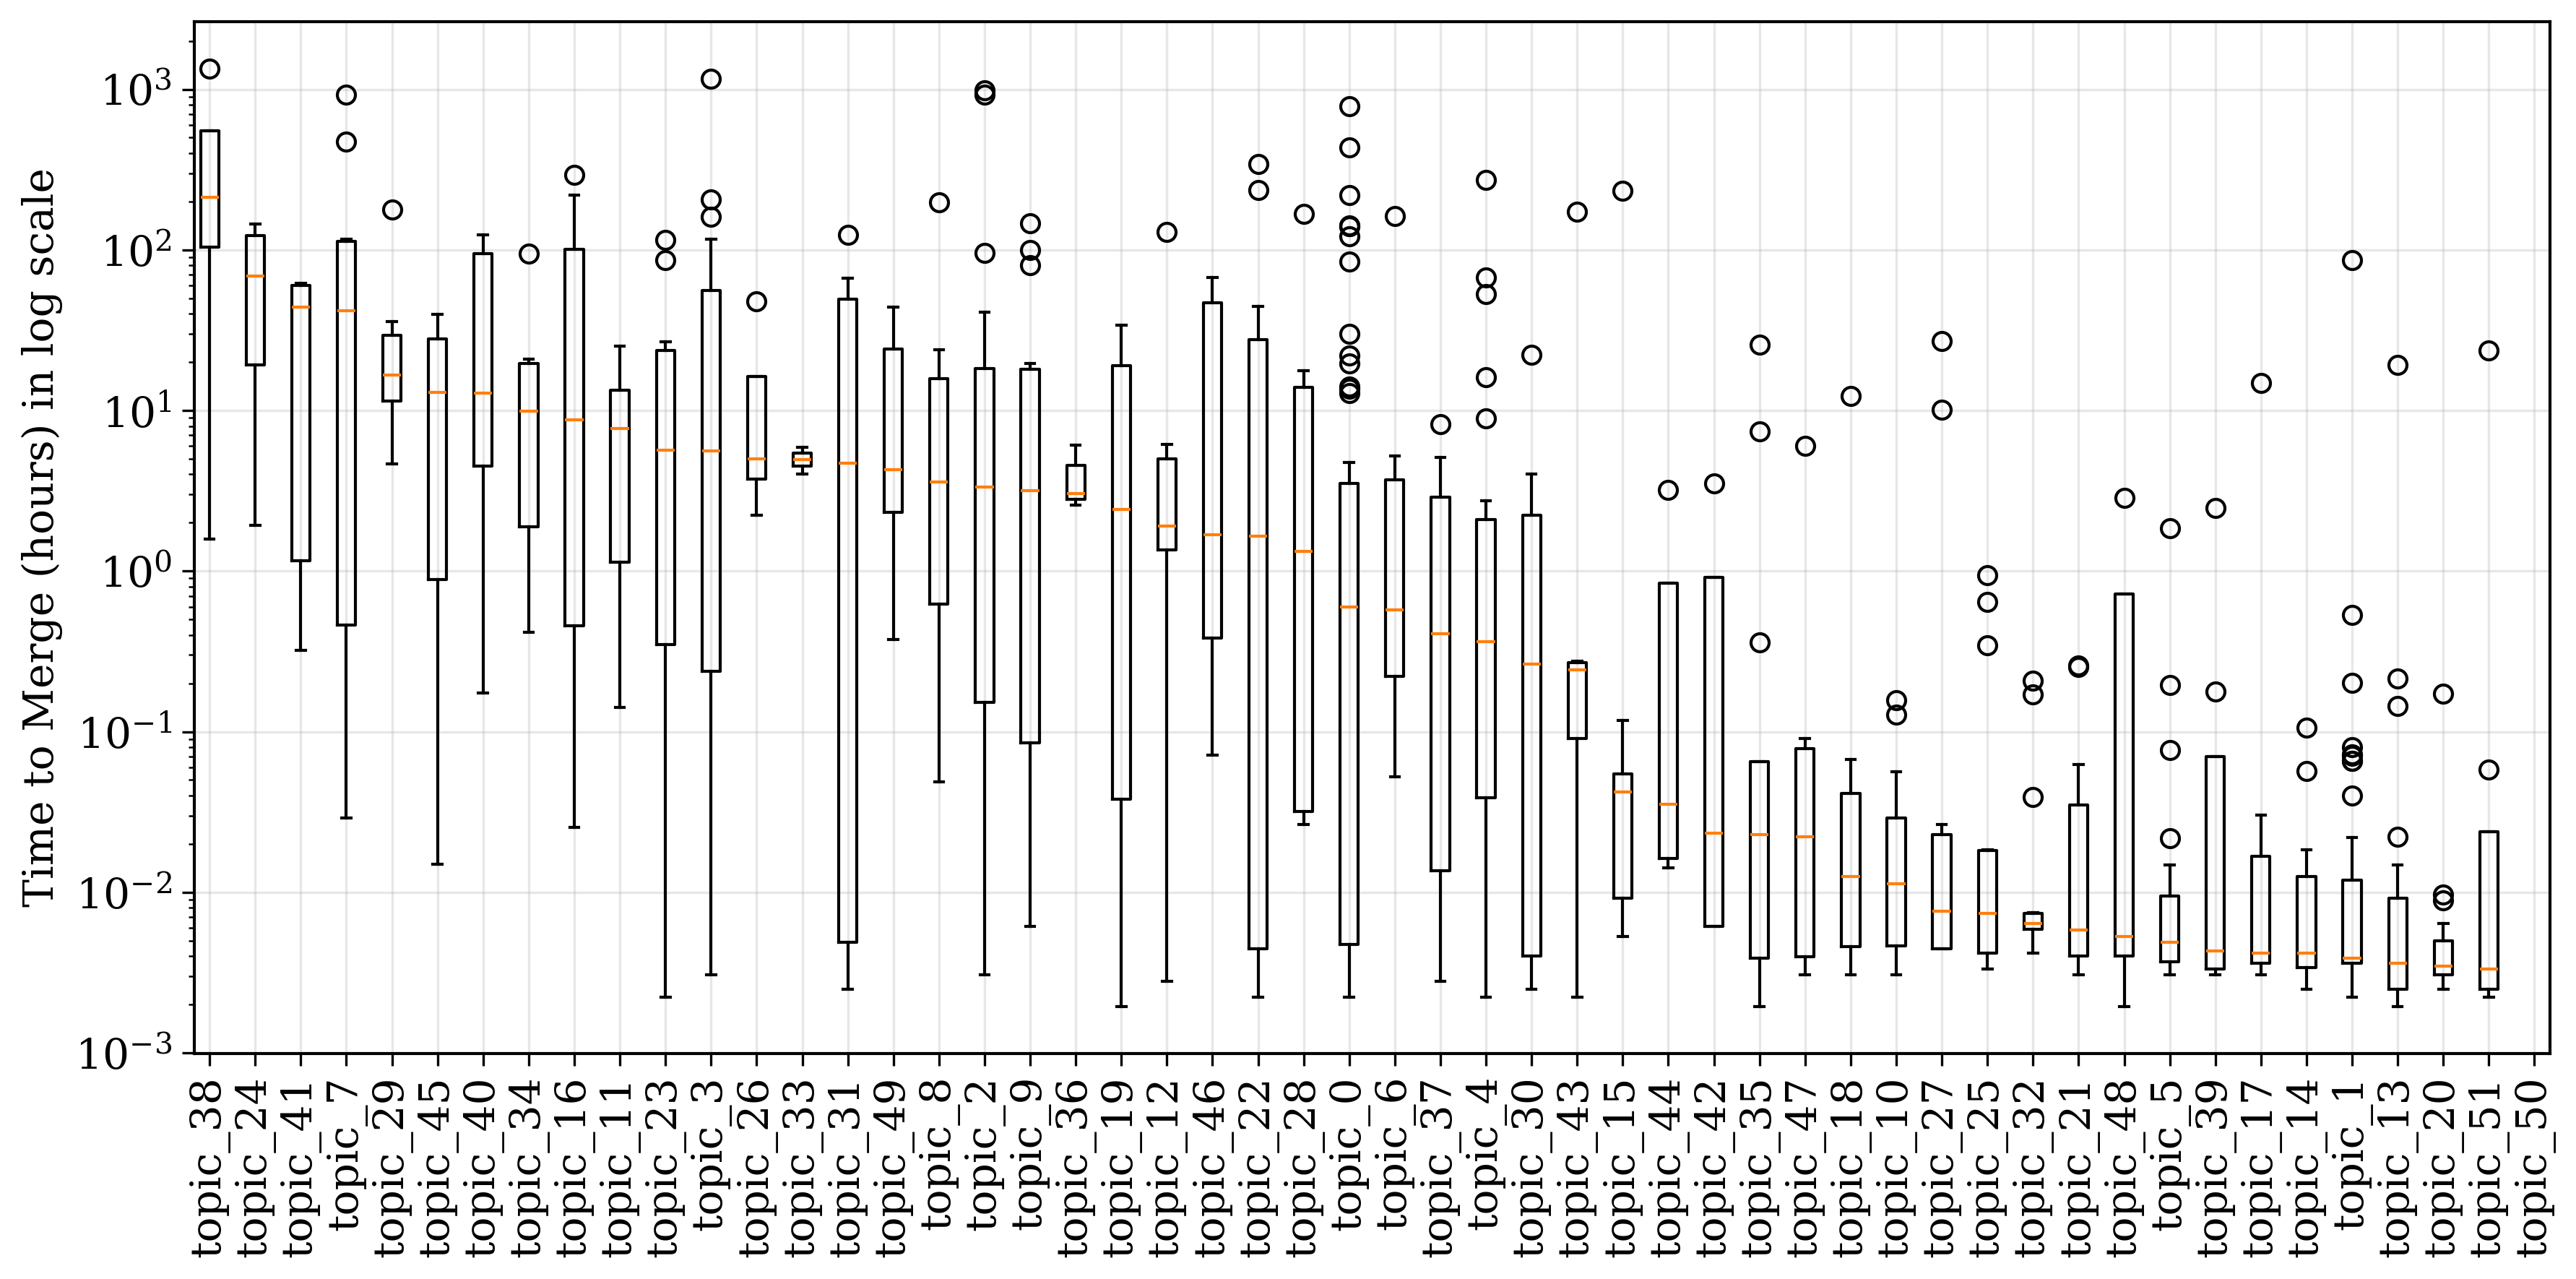

In [126]:
times_to_merge = []
median = []
labels = []

unit = "hours"

for topic, df in topics.items():
    merge_times = get_time_to_merge(df, unit=unit)
    times_to_merge.append(merge_times)
    median.append(np.median(merge_times))
    labels.append(topic)

stat = pd.DataFrame({
    'Topic': labels,
    'Median': median,
    'TimeToMerge': times_to_merge
})

stat = stat.sort_values(by='Median', ascending=False)

plt.figure(figsize=(12, 6))
positions = np.arange(len(stat)) * 1.5
plt.boxplot(stat["TimeToMerge"], positions=positions, widths=0.6)
plt.xticks(positions, stat["Topic"], rotation=90, ha='center')
plt.yscale('log')
plt.ylabel(f'Time to Merge ({unit}) in log scale')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [129]:
print(stat["Topic"].tolist())

['topic_38', 'topic_24', 'topic_41', 'topic_7', 'topic_29', 'topic_45', 'topic_40', 'topic_34', 'topic_16', 'topic_11', 'topic_23', 'topic_3', 'topic_26', 'topic_33', 'topic_31', 'topic_49', 'topic_8', 'topic_2', 'topic_9', 'topic_36', 'topic_19', 'topic_12', 'topic_46', 'topic_22', 'topic_28', 'topic_0', 'topic_6', 'topic_37', 'topic_4', 'topic_30', 'topic_43', 'topic_15', 'topic_44', 'topic_42', 'topic_35', 'topic_47', 'topic_18', 'topic_10', 'topic_27', 'topic_25', 'topic_32', 'topic_21', 'topic_48', 'topic_5', 'topic_39', 'topic_17', 'topic_14', 'topic_1', 'topic_13', 'topic_20', 'topic_51', 'topic_50']


## Duration groups

In [118]:
def plot_grouped_barchart(df, output_dir = None, loc="center right"):
    categories = df['Type'].unique()
    durations = df['Duration'].unique()
    bar_width = 0.25
    x = np.arange(len(categories))

    fig, ax = plt.subplots(figsize=(16, 7))

    # Hatching patterns for different durations
    hatches = ['//', '..', 'xx']  # Adjust or add more if needed

    # Optional: neutral color to keep visual simplicity
    base_color = '#cccccc'

    for i, duration in enumerate(durations):
        values = df[df['Duration'] == duration]['Proportion'].apply(lambda x: x.split("%")[0]).astype(float)
        bars = ax.bar(
            x + i * bar_width,
            values,
            width=bar_width,
            label=duration,
            color=base_color,
            hatch=hatches[i % len(hatches)],
            edgecolor='black'  # optional: makes hatch visible
        )

        # Add count labels on top of bars
        for bar, prop in zip(bars, df[df['Duration'] == duration]['Count']):
            height = bar.get_height()
            ax.annotate(prop,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        rotation=90)

    ax.spines[['top']].set_visible(False)
    ax.set_xlabel('Issue Subcategory')
    ax.set_ylabel('% Of Issues')
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(categories, rotation=30, ha='right')
    #ax.axhline(y=85, color='red', linestyle='--', linewidth=2, label='85% Threshold')
    ax.legend(title='', loc=loc)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    if output_dir is not None:
        plt.savefig(output_dir + ".png", dpi=300)
        plt.savefig(output_dir + ".pdf", dpi=300, format="pdf")
        plt.savefig(output_dir + ".svg", format="svg")
    plt.show()

In [123]:
all_durations = ["within a day", "within a week", "more than a week"]

summary_data = []

for topic, df in topics.items():
    df = df.copy()
    df["time_to_merge"] = get_time_to_merge(df, unit='days')
    df["Duration"] = pd.cut(
        df["time_to_merge"],
        bins=[-1, 1, 7, float("inf")],
        labels=all_durations
    )
    
    duration_counts = df["Duration"].value_counts().reindex(all_durations, fill_value=0)
    total_count = duration_counts.sum()
    
    for duration in all_durations:
        count = duration_counts[duration]
        proportion = (count / total_count) * 100 if total_count > 0 else 0
        summary_data.append([topic, duration, count, f"{proportion:.2f}%"])

summary_df = pd.DataFrame(summary_data, columns=["Type", "Duration", "Count", "Proportion"])

summary_df

,Type,Duration,Count,Proportion
0,topic_12,within a day,6,85.71%
1,topic_12,within a week,1,14.29%
2,topic_12,more than a week,0,0.00%
3,topic_15,within a day,12,92.31%
4,topic_15,within a week,0,0.00%
...,...,...,...,...
151,topic_23,within a week,3,27.27%
152,topic_23,more than a week,0,0.00%
153,topic_36,within a day,3,100.00%
154,topic_36,within a week,0,0.00%


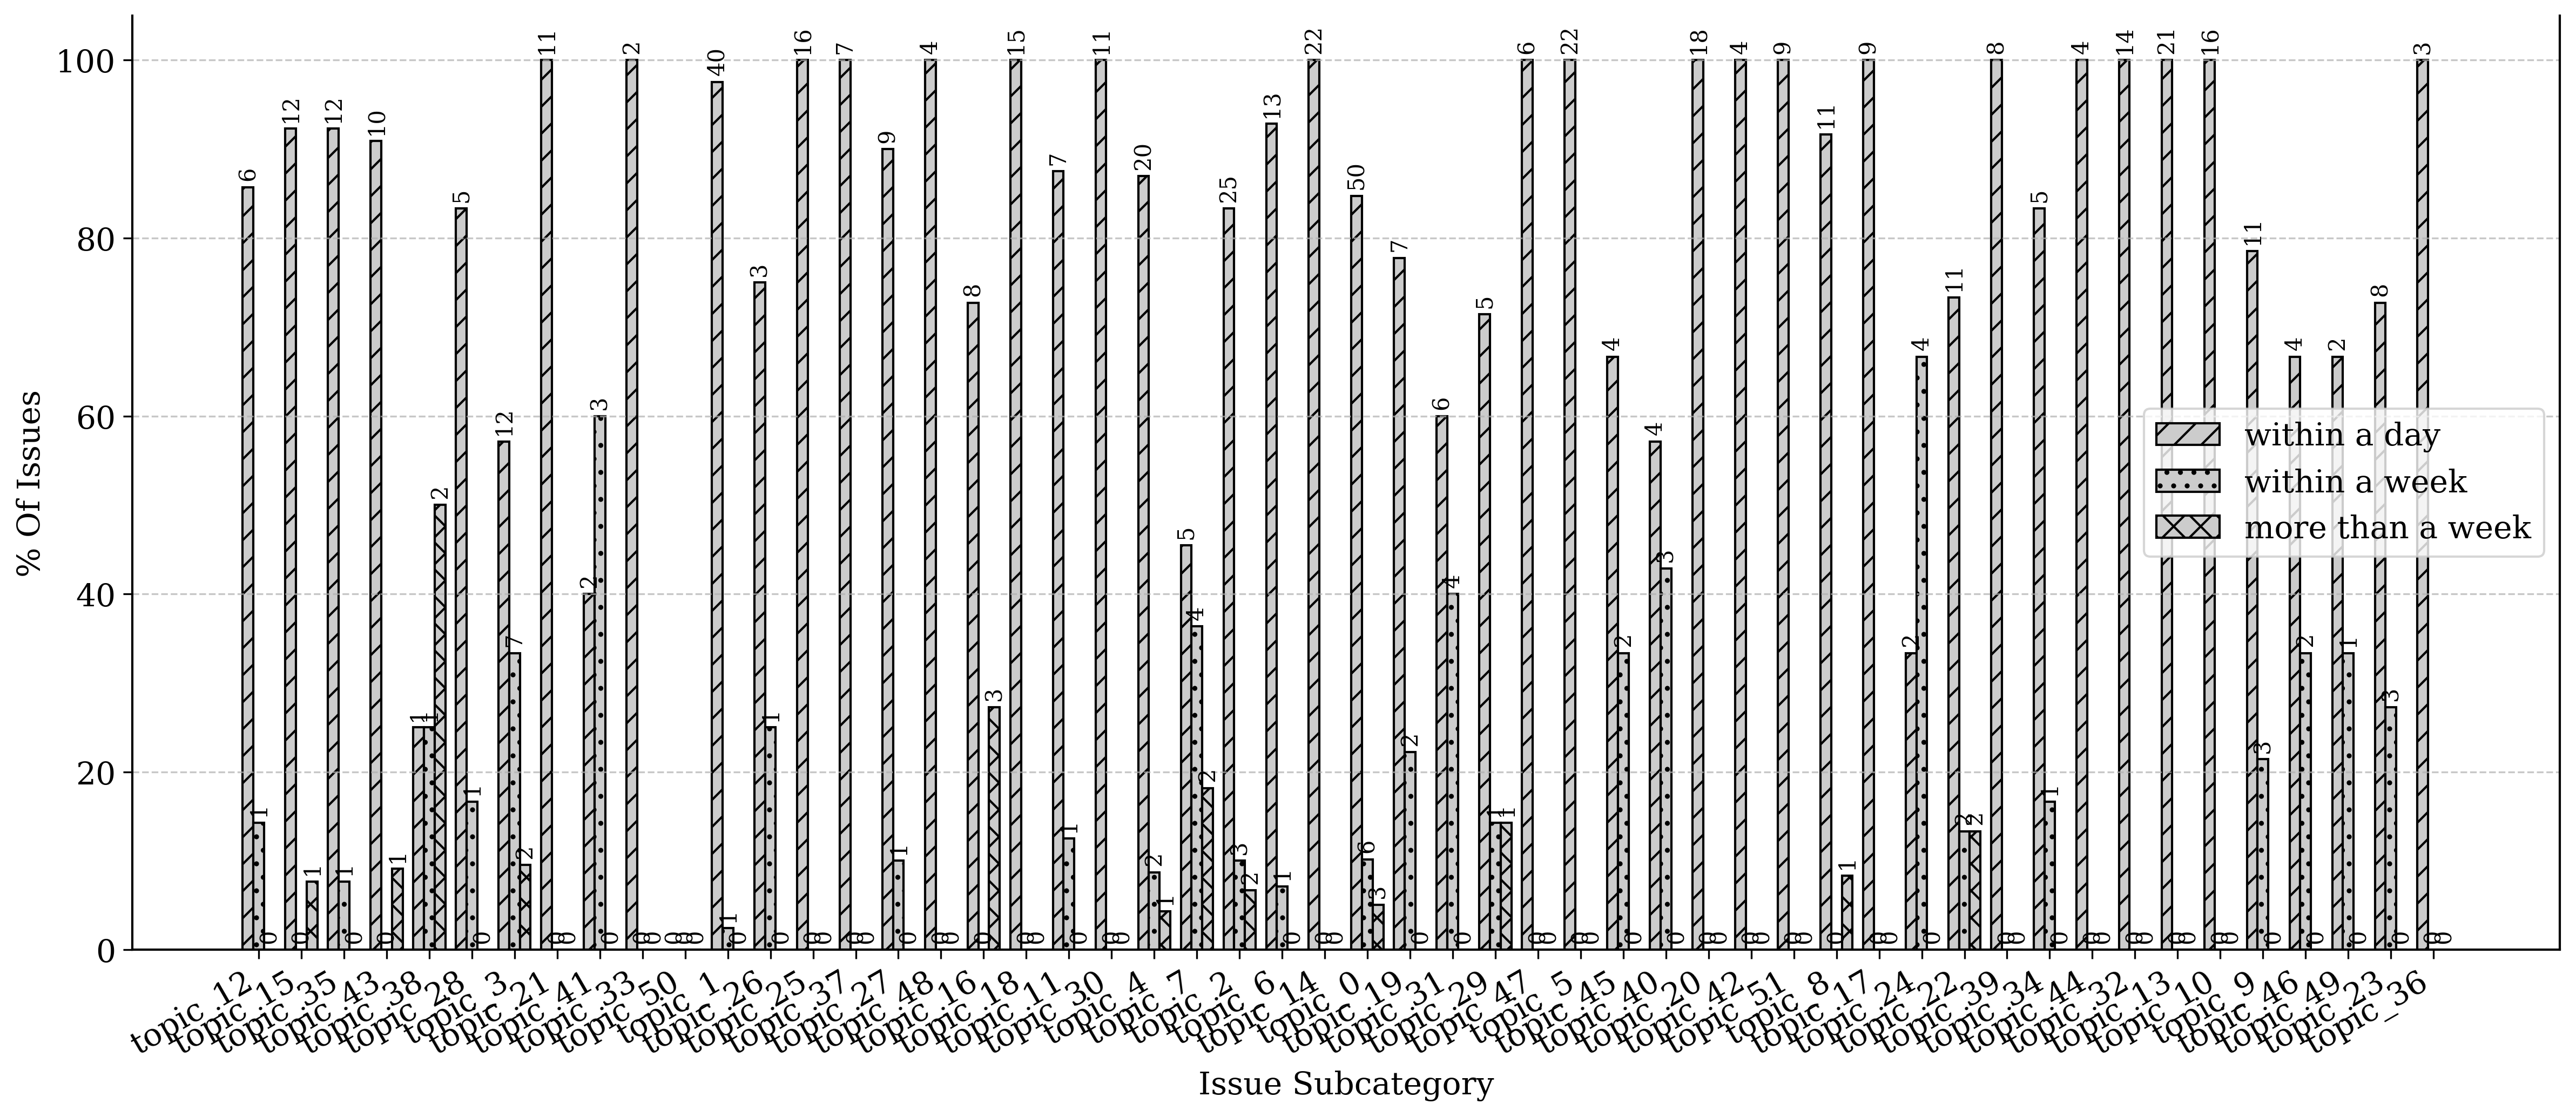

In [124]:
plot_grouped_barchart(summary_df)